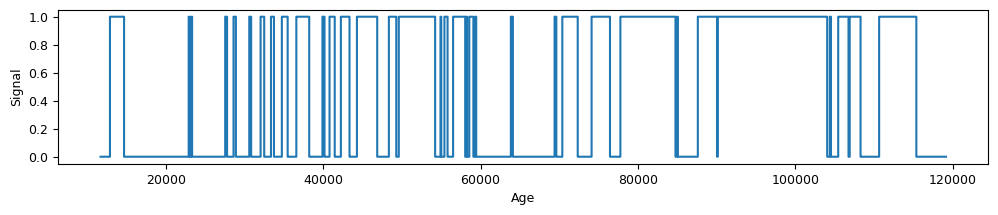

In [306]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Given ground truth intervals for the low phase (-1)
gs_data = {
    "start": [11703, 14692, 23020, 23340, 27780, 28900, 30840, 32500, 33740, 35480,
              38220, 40160, 41460, 43340, 46860, 49280, 54220, 55000, 55800, 58040,
              58280, 59080, 59440, 64100, 69620, 72340, 76440, 84760, 85060, 90040,
              104040,104520,106750,108280,115370],
    "end":   [12896, 22900, 23220, 27540, 28600, 30600, 32040, 33360, 34740, 36580,
              39900, 40800, 42240, 44280, 48340, 49600, 54900, 55400, 56500, 58160,
              58560, 59300, 63840, 69400, 70380, 74100, 77760, 84960, 87600, 90140,
              104380,105440,106900,110640,119140]
}

# Create an age vector (baseline resolution e.g. every 10 years)
ages = np.arange(11703, 119140, 1)

# Initialize signal at +1
signal = np.ones_like(ages)

# Flip to -1 during the specified low-phase intervals
for start, end in zip(gs_data["start"], gs_data["end"]):
    mask = (ages >= start) & (ages <= end)
    signal[mask] = 0

# Build a DataFrame for clarity
df_sq = pd.DataFrame({"age": ages, "sq": signal})

# Plot the irregular square wave
plt.figure(figsize=(12, 2))
plt.step(df_sq["age"], df_sq["sq"], where="post")
plt.xlabel("Age")
plt.ylabel("Signal")
# plt.title("Irregular Square Wave Signal")
plt.show()


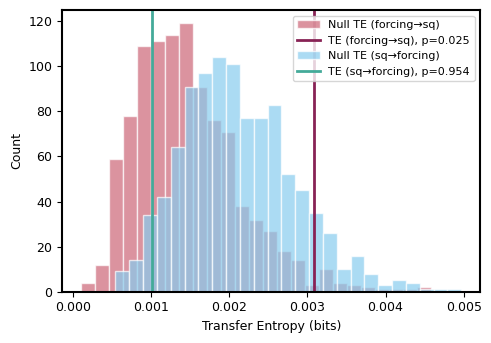

True


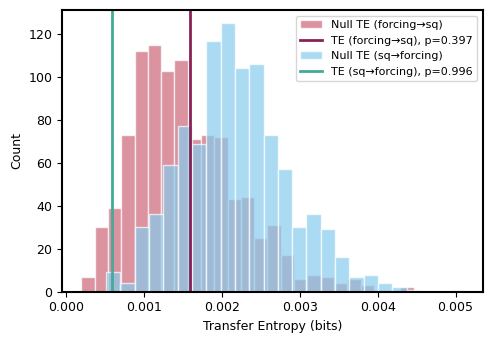

False


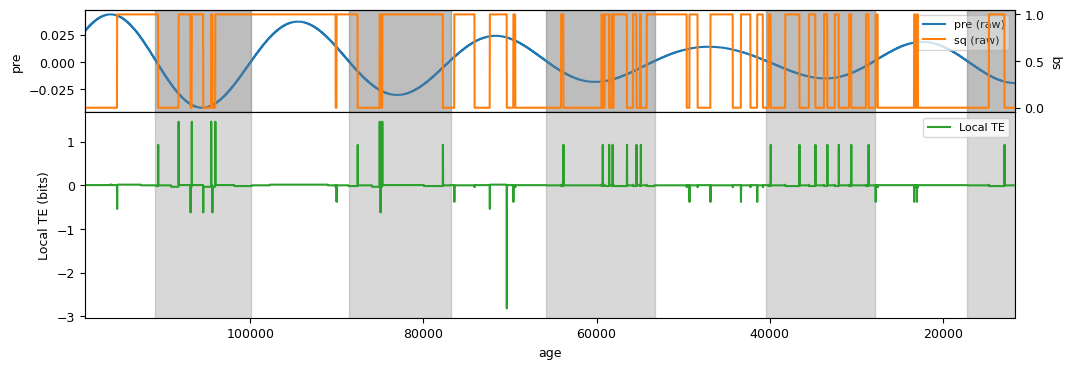

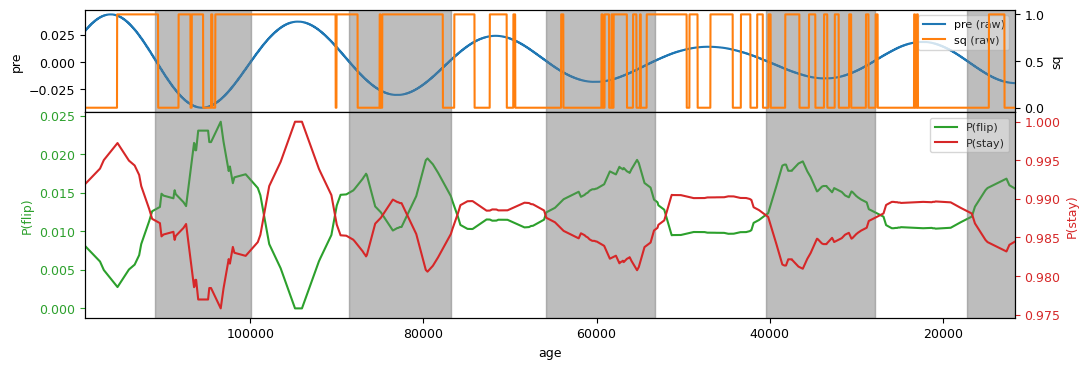

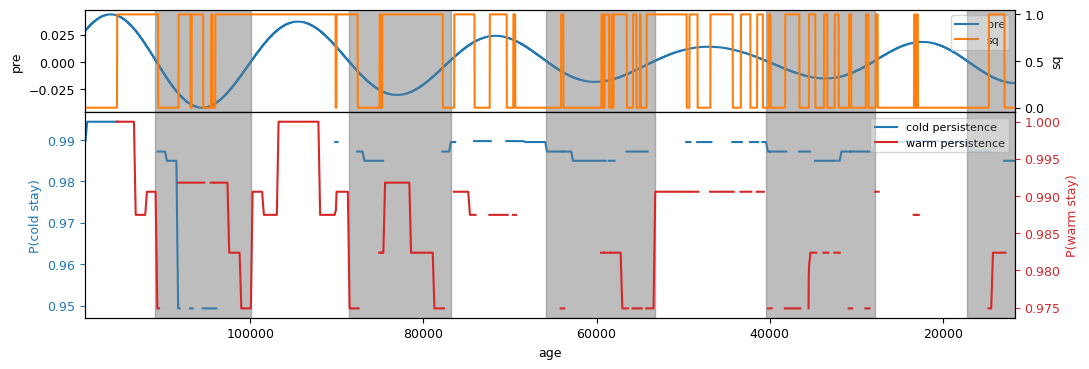

In [307]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

df_sq_i, df_pre_i, df_obl_i = sa.interpolate_data_forcing(df_sq.copy(), 20, if_plot=False)


pre = df_pre_i['pre'].values      # source (precession)
obl = df_obl_i['obl'].values      # forcing (obliquity)
sq = df_sq_i['sq'].values    # target (residual)


result,fig=sa.transfer_entropy_surrogate_test(pre,sq, forcing_bins=6, sq_bins=2, sq_method='quantile', binary=True, n_surr=1000)

# fig.savefig('TE_NGRIP.pdf',format='pdf',bbox_inches='tight')

print(result)

result, fig = sa.transfer_entropy_surrogate_test(obl, sq, k=1, forcing_bins=6, sq_bins=2, sq_method='quantile', n_surr=1000)
print(result)


from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

LTE = sa.local_TE(df_pre_i, df_sq_i,
                   forcing_column='pre',
                   target_column='sq',
                   time_column='age',
                   nbins_pre=4,
                   nbins_target=2)

Lp = sa.local_prob(df_pre_i.copy(), df_sq_i.copy(),
                   forcing_column='pre',
                   target_column='sq',
                   time_column='age',
                   nbins_pre=6,
                   smooth_win=300)


Lp = sa.local_stay_split(df_pre_i.copy(), df_sq_i.copy(),
                   forcing_column='pre',
                   target_column='sq',
                   time_column='age',
                   nbins_pre=6,
                   smooth_win=10)

# Stability of TE to event identifications

In [175]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

def perturb_sequence(df, n_events=10, min_len=1, max_len=10, random_state=None, plot=True):
    """
    Perturb a binary stadial/interstadial sequence by inserting N spurious events.

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain columns 'age' and 'sq' (0 or 1).
    n_events : int
        Number of random segments to insert.
    max_len : int
        Maximum length (in samples) of each inserted segment.
    random_state : int or None
        Seed for reproducibility.
    plot : bool
        If True, overlays original vs perturbed sequences.

    Returns
    -------
    df_pert : pandas.DataFrame
        A copy of `df` with new column 'sq_pert' for the perturbed sequence.
    f1 : float
        Macro-averaged F₁ score comparing original 'sq' to 'sq_pert'.
    """
    rng = np.random.RandomState(random_state)
    seq_orig = df['sq'].values
    seq_pert = seq_orig.copy()
    L = len(seq_orig)

    # Insert random segments
    for _ in range(n_events):
        length = rng.randint(min_len, max_len + 1)
        start = rng.randint(0, L - length)
        new_state = rng.choice([0, 1])
        seq_pert[start:start + length] = new_state

    # Compute F1 (macro-average)
    f1 = f1_score(seq_orig, seq_pert, average='macro')

    # Build output DataFrame
    df_pert = df.copy()
    df_pert['sq'] = seq_pert

    # Plot overlay
    if plot:
        plt.figure(figsize=(12, 3))
        plt.step(df['age'], seq_orig, where='post', label='Original', linewidth=1)
        plt.step(df['age'], seq_pert, where='post', label='Perturbed', alpha=0.7, linewidth=1)
        plt.xlabel('Age')
        plt.ylabel('sq')
        plt.title(f'Original vs Perturbed (F₁₍macro₎ = {f1:.3f})')
        plt.legend(loc='upper right')
        plt.tight_layout()
        plt.show()

    return df_pert, f1


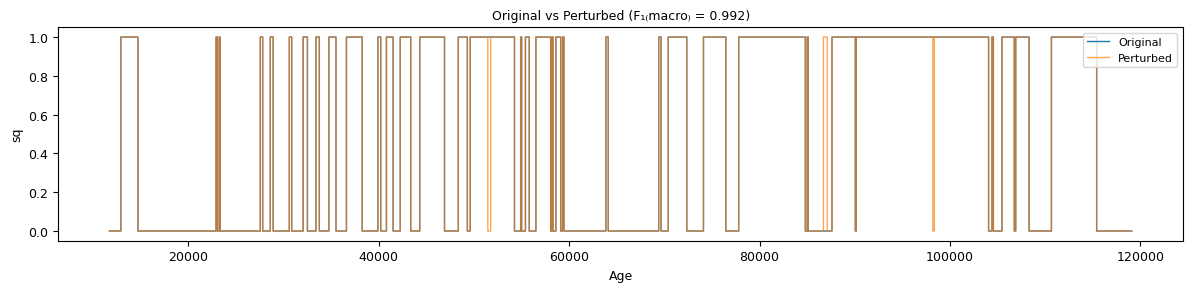

Perturbed F₁ score: 0.992


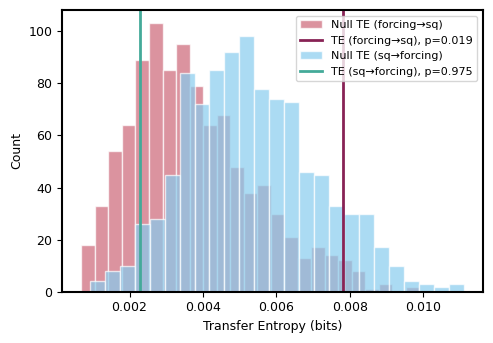

In [238]:
# assuming df_sq is your original DataFrame with 'age' and 'sq':
df_sq_i, df_pre_i, df_obl_i = sa.interpolate_data_forcing(df_sq.copy(), 50, if_plot=False)
df_pert, f1 = perturb_sequence(df_sq_i, n_events=10, min_len=3, max_len=10, plot=True)
print(f"Perturbed F₁ score: {f1:.3f}")


pre = df_pre_i['pre'].values
obl = df_obl_i['obl'].values
sq  = df_pert['sq'].values
result, fig = sa.transfer_entropy_surrogate_test(
    pre, sq,
    forcing_bins=6, sq_bins=2,
    sq_method='quantile',
    binary=True,
    n_surr=1000
)


In [151]:
result

True

# Monte Carlo

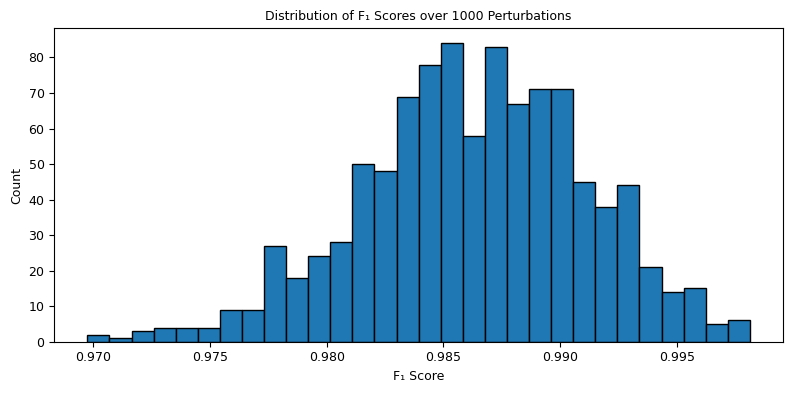

TE test was significant in 69.3% of the 1000 runs


In [239]:
import numpy as np
import matplotlib.pyplot as plt

n_iter = 1000
f1_scores = []
sig_flags = []

pre = df_pre_i['pre'].values
obl = df_obl_i['obl'].values

for i in range(n_iter):
    # 1) perturb (no plot, seed=i for reproducibility)
    df_pert, f1 = perturb_sequence(
        df_sq_i,
        n_events=10,
        min_len=2,
        max_len=10,
        plot=False,
        random_state=i
    )
    f1_scores.append(f1)

    # 2) re‐run TE

    sq  = df_pert['sq'].values

    result, _ = sa.transfer_entropy_surrogate_test(
        pre, sq,
        forcing_bins=6,
        sq_bins=2,
        sq_method='quantile',
        binary=True,
        n_surr=1000,
        if_plot=False,
    )

    # 3) result is already a bool
    sig_flags.append(bool(result))

# Plot histogram of F1 scores
plt.figure(figsize=(8, 4))
plt.hist(f1_scores, bins=30, edgecolor='k')
plt.xlabel('F₁ Score')
plt.ylabel('Count')
plt.title(f'Distribution of F₁ Scores over {n_iter} Perturbations')
plt.tight_layout()
plt.show()

# Print percentage significant
percent_sig = np.mean(sig_flags) * 100
print(f"TE test was significant in {percent_sig:.1f}% of the {n_iter} runs")


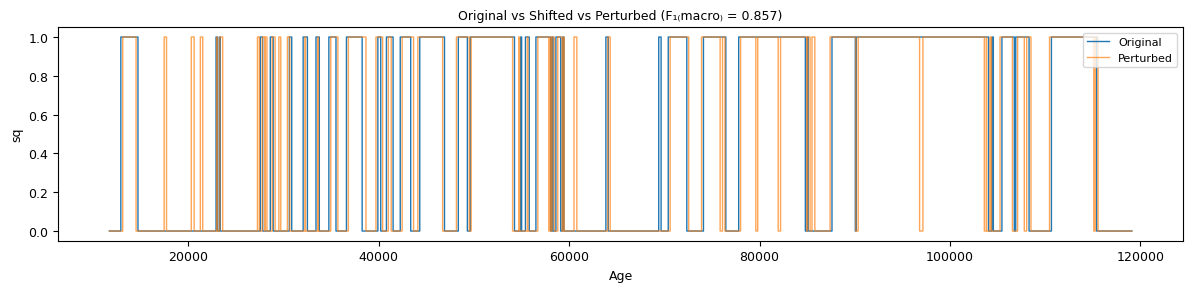

Perturbed F₁ score: 0.857


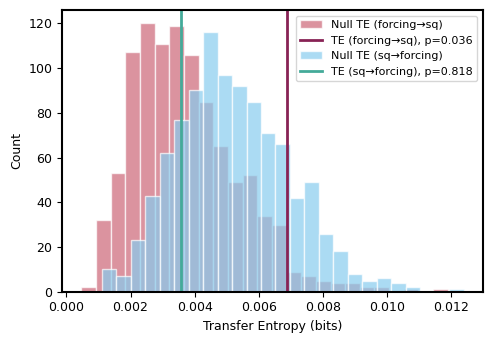

In [302]:
from toolbox import syn_test as syn_t
import importlib; 
importlib.reload(syn_t)


# assuming df_sq is your original DataFrame with 'age' and 'sq':
df_sq_i, df_pre_i, df_obl_i = sa.interpolate_data_forcing(df_sq.copy(), 50, if_plot=False)
df_pert, f1 = syn_t.perturb_sequence_v2(df_sq_i, n_events=41, min_len=3, max_len=6, trans_shift=4, plot=True)
print(f"Perturbed F₁ score: {f1:.3f}")


pre = df_pre_i['pre'].values
obl = df_obl_i['obl'].values
sq  = df_pert['sq'].values
result, fig = sa.transfer_entropy_surrogate_test(
    pre, sq,
    forcing_bins=6, sq_bins=2,
    sq_method='quantile',
    binary=True,
    n_surr=1000
)


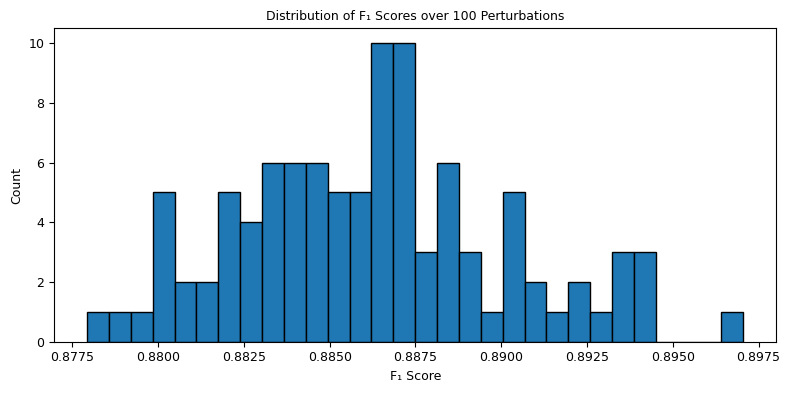

TE test was significant in 54.0% of the 100 runs


In [289]:
import numpy as np
import matplotlib.pyplot as plt

n_iter = 100
f1_scores = []
sig_flags = []

pre = df_pre_i['pre'].values
obl = df_obl_i['obl'].values

for i in range(n_iter):
    # 1) perturb (no plot, seed=i for reproducibility)
    df_pert, f1 = perturb_sequence_v2(df_sq_i, n_events=41, min_len=1, max_len=1, trans_shift=4, plot=False)
    f1_scores.append(f1)

    # 2) re‐run TE

    sq  = df_pert['sq'].values

    result, _ = sa.transfer_entropy_surrogate_test(
        pre, sq,
        forcing_bins=6,
        sq_bins=2,
        sq_method='quantile',
        binary=True,
        n_surr=1000,
        if_plot=False,
    )

    # 3) result is already a bool
    sig_flags.append(bool(result))

# Plot histogram of F1 scores
plt.figure(figsize=(8, 4))
plt.hist(f1_scores, bins=30, edgecolor='k')
plt.xlabel('F₁ Score')
plt.ylabel('Count')
plt.title(f'Distribution of F₁ Scores over {n_iter} Perturbations')
plt.tight_layout()
plt.show()

# Print percentage significant
percent_sig = np.mean(sig_flags) * 100
print(f"TE test was significant in {percent_sig:.1f}% of the {n_iter} runs")


max-power row = 59   →  period ≈ 23.6 ka


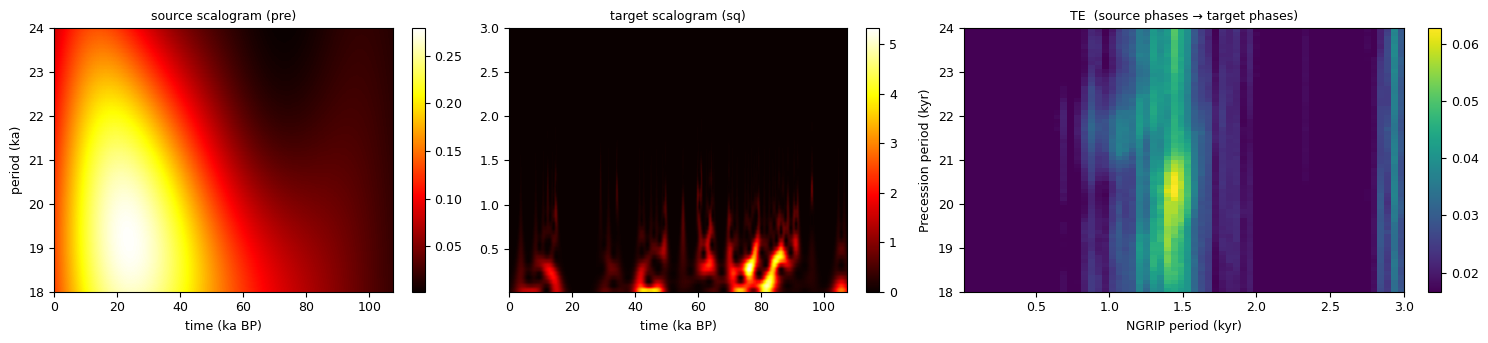

[[0.00694503 0.00211887 0.00467876 ... 0.02504892 0.03805862 0.02914294]
 [0.00716478 0.00205322 0.0046301  ... 0.02557216 0.03729319 0.02968131]
 [0.00755896 0.00241502 0.00493772 ... 0.02660108 0.0378926  0.02993964]
 ...
 [0.00682456 0.00266874 0.00510271 ... 0.02404675 0.03317068 0.02794413]
 [0.00676271 0.00270134 0.0051497  ... 0.0241076  0.03304721 0.02819821]
 [0.00667167 0.00258934 0.00503594 ... 0.0243539  0.03323452 0.02894486]]


In [308]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

te_mat, p_src, p_trg = sa.freq_resolved_te(
    x = pre,             # forcing   (chronological order!)
    y = sq,              # response
    sampling_period = 20,     # yr/pt
    # source band: narrow around 20 ka
    src_min_period = 18_000,
    src_max_period = 24_000,
    n_src_scales   = 64,
    # target band: 0.1–3 ka
    trg_min_period = 10,
    trg_max_period = 3_000,
    n_trg_scales   = 64,
    k = 1,
    plot = True,
    source_vname='Precession',       # e.g. 'pre'
    target_vname='NGRIP'        # e.g. 'sq'
)
print(te_mat)

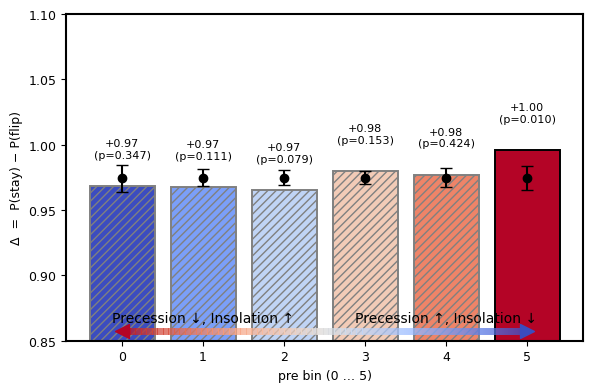

In [309]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)


delta, mu, sigma, p = sa.prob_prebins_diffbar_surr(
        df_pre_i, df_sq_i,
        forcing_column='pre',
        target_column='sq',
        nbins_pre=6,
        n_surr=1000,
        alpha=0.05,
        y_min=0.85,
        y_max=1.1,
        random_state=0   # reproducible
)

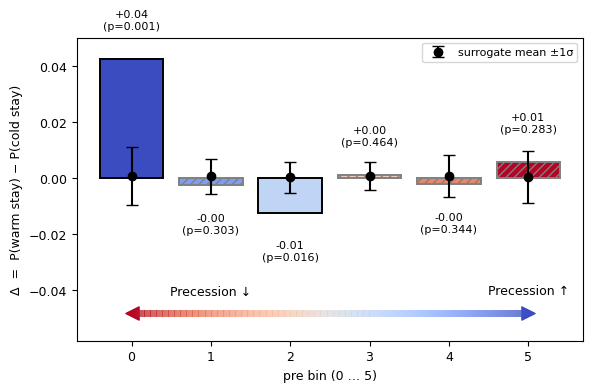

In [310]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

delta, mu, sd, p = sa.prob_prebins_staydiff_surr(
    df_pre      = df_pre_i.copy(),
    df_sq       = df_sq_i.copy(),
    forcing_column='pre',
    target_column='sq',
    nbins_pre   = 6,
    n_surr      = 1000,
    alpha       = 0.05,
    random_state=0
)